In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

#1. Formulate your questions

How do socioeconomic indicators like income, education, employment, and inequality affect the rate of fatal vehicle collisions in U.S. states?

#2 Read The data

Here, I'll read in all the data from the various sites. I downloaded the data as a csv, then addded them to a folder in github (it will be set to public during the grading period, but not otherwise as I do not want folks to use the data in an academically disingenuous way). Once in, I will do some basic scrubbing I order to merge the datasets together.

In [ ]:
safety_path = "https://raw.githubusercontent.com/harsh1399/DS2500-Data_Wrangling/main/Module_Assignment-1/Highway_Safety_Data/bad-drivers.csv"
edu_path = "https://raw.githubusercontent.com/jcraw005/DS2500Data/main/ACSST1Y2023.S1501-Data.csv"
gini_path = "https://raw.githubusercontent.com/jcraw005/DS2500Data/main/ACSDT1Y2023.B19083-Data.csv"
emp_path = "https://raw.githubusercontent.com/jcraw005/DS2500Data/main/ACSDP1Y2023.DP03-Data.csv"
unemp_path = "https://raw.githubusercontent.com/jcraw005/DS2500Data/main/state_rates.csv"

df_safety = pd.read_csv(safety_path)
df_edu = pd.read_csv(edu_path)
df_gini = pd.read_csv(gini_path)
df_emp = pd.read_csv(emp_path)
df_unemp = pd.read_csv(unemp_path)

Clean the NHSB data

In [ ]:
df_safety.columns = df_safety.columns.str.strip().str.lower().str.replace(' ', '_')

Clean the education dataset

In [ ]:
df_edu = df_edu[df_edu['NAME'] != 'Geographic Area Name']
df_edu = df_edu[['NAME', 'S1501_C01_006E', 'S1501_C01_012E']]
df_edu.columns = ['state', 'pct_high_school_or_higher', 'pct_bachelors_or_higher']
df_edu[['pct_high_school_or_higher', 'pct_bachelors_or_higher']] = df_edu[
    ['pct_high_school_or_higher', 'pct_bachelors_or_higher']
].apply(pd.to_numeric, errors='coerce')

Clean the Gini dataset

In [ ]:
df_gini = df_gini[df_gini['NAME'] != 'Geographic Area Name']
df_gini = df_gini[['NAME', 'B19083_001E']].rename(columns={'NAME': 'state', 'B19083_001E': 'gini_index_2023'})
df_gini['gini_index_2023'] = pd.to_numeric(df_gini['gini_index_2023'], errors='coerce')

Clean the employment dataset

In [ ]:
df_emp = df_emp[df_emp['NAME'] != 'Geographic Area Name']
df_emp = df_emp[['NAME', 'DP03_0001E', 'DP03_0002E']]
df_emp.columns = ['state', 'population_16+', 'labor_force']
df_emp['population_16+'] = pd.to_numeric(df_emp['population_16+'], errors='coerce')
df_emp['labor_force'] = pd.to_numeric(df_emp['labor_force'], errors='coerce')
df_emp['employment_ratio'] = (df_emp['labor_force'] / df_emp['population_16+']) * 100

Clean the unempleoyment dataset

In [ ]:
df_unemp.columns = df_unemp.columns.str.lower().str.replace(' ', '_')
df_unemp = df_unemp.drop(columns=['rank'], errors='ignore')
df_unemp = df_unemp.rename(columns={'2024_rate': 'unemployment_rate_2024'})

#Merge the datasets

In [ ]:
merged_df = df_safety.merge(df_unemp, on='state', how='left')
merged_df = merged_df.merge(df_edu, on='state', how='left')
merged_df = merged_df.merge(df_gini, on='state', how='left')
merged_df = merged_df.merge(df_emp[['state', 'employment_ratio']], on='state', how='left')

key_columns = [
    'gini_index_2023', 'pct_high_school_or_higher',
    'pct_bachelors_or_higher', 'unemployment_rate_2024', 'employment_ratio'
]
df = merged_df.dropna(subset=key_columns)

df = df.rename(columns={
    '2023_gini_index': 'gini_index_2023',
    '2024_unemployment_rate': 'unemployment_rate_2024'
})

In [ ]:
df.rename(columns={'percentage_of_drivers_involved_in_fatal_collisions_who_were_alcohol-impaired': 'percentage_of_drivers_involved_in_fatal_collisions_who_were_alcohol_impaired'}, inplace=True)

#3. Check the packaging:

In [ ]:
df.shape

(51, 13)

In [ ]:
df.columns

Index(['state',
       'number_of_drivers_involved_in_fatal_collisions_per_billion_miles',
       'percentage_of_drivers_involved_in_fatal_collisions_who_were_speeding',
       'percentage_of_drivers_involved_in_fatal_collisions_who_were_alcohol_impaired',
       'percentage_of_drivers_involved_in_fatal_collisions_who_were_not_distracted',
       'percentage_of_drivers_involved_in_fatal_collisions_who_had_not_been_involved_in_any_previous_accidents',
       'car_insurance_premiums_($)',
       'losses_incurred_by_insurance_companies_for_collisions_per_insured_driver_($)',
       'unemployment_rate_2024', 'pct_high_school_or_higher',
       'pct_bachelors_or_higher', 'gini_index_2023', 'employment_ratio'],
      dtype='object')

#4. Look at the top and bottom of data

In [ ]:
df.head(10)

,state,number_of_drivers_involved_in_fatal_collisions_per_billion_miles,percentage_of_drivers_involved_in_fatal_collisions_who_were_speeding,percentage_of_drivers_involved_in_fatal_collisions_who_were_alcohol_impaired,percentage_of_drivers_involved_in_fatal_collisions_who_were_not_distracted,percentage_of_drivers_involved_in_fatal_collisions_who_had_not_been_involved_in_any_previous_accidents,car_insurance_premiums_($),losses_incurred_by_insurance_companies_for_collisions_per_insured_driver_($),unemployment_rate_2024,pct_high_school_or_higher,pct_bachelors_or_higher,gini_index_2023,employment_ratio
0,Alabama,18.8,39,30,96,80,784.55,145.08,3.3,3498967,616025,0.4771,58.569905
1,Alaska,18.1,41,25,90,94,1053.48,133.93,4.7,493892,99091,0.4492,66.819483
2,Arizona,18.6,35,28,84,96,899.47,110.35,4.0,5150254,1051136,0.4650,60.749426
3,Arkansas,22.4,18,26,94,95,827.34,142.39,3.6,2078254,345836,0.4740,58.751217
4,California,12.0,35,28,91,89,878.41,165.63,5.4,26969649,6137666,0.4870,64.267805
5,Colorado,13.6,37,28,79,95,835.50,139.91,4.7,4135123,1170106,0.4575,68.967801
6,Connecticut,10.8,46,36,87,82,1068.73,167.02,3.4,2559922,591246,0.4954,66.392711
7,Delaware,16.2,38,30,87,99,1137.87,151.48,3.6,731427,153565,0.4557,62.230303
8,District of Columbia,5.9,34,27,100,100,1273.89,136.05,5.4,482919,129951,0.5163,72.773907
9,Florida,17.9,21,29,92,94,1160.13,144.18,3.6,16421870,3550180,0.4829,60.036508


In [ ]:
df.tail()

,state,number_of_drivers_involved_in_fatal_collisions_per_billion_miles,percentage_of_drivers_involved_in_fatal_collisions_who_were_speeding,percentage_of_drivers_involved_in_fatal_collisions_who_were_alcohol_impaired,percentage_of_drivers_involved_in_fatal_collisions_who_were_not_distracted,percentage_of_drivers_involved_in_fatal_collisions_who_had_not_been_involved_in_any_previous_accidents,car_insurance_premiums_($),losses_incurred_by_insurance_companies_for_collisions_per_insured_driver_($),unemployment_rate_2024,pct_high_school_or_higher,pct_bachelors_or_higher,gini_index_2023,employment_ratio
46,Virginia,12.7,19,27,87,88,768.95,153.72,3.1,6037339,1446760,0.4723,65.265643
47,Washington,10.6,42,33,82,86,890.03,111.62,4.4,5511197,1340967,0.4703,65.067968
48,West Virginia,23.8,34,28,97,87,992.61,152.56,3.9,1259219,182741,0.4679,54.357005
49,Wisconsin,13.8,36,33,39,84,670.31,106.62,3.2,4116216,914463,0.4479,65.242932
50,Wyoming,17.4,42,32,81,90,791.14,122.04,3.5,403853,77762,0.4455,63.538473


#5. Check the "n"s

In [ ]:
df['state'].nunique()

51

#6. Validate against an external knowledge or data source

#7. Make a plot

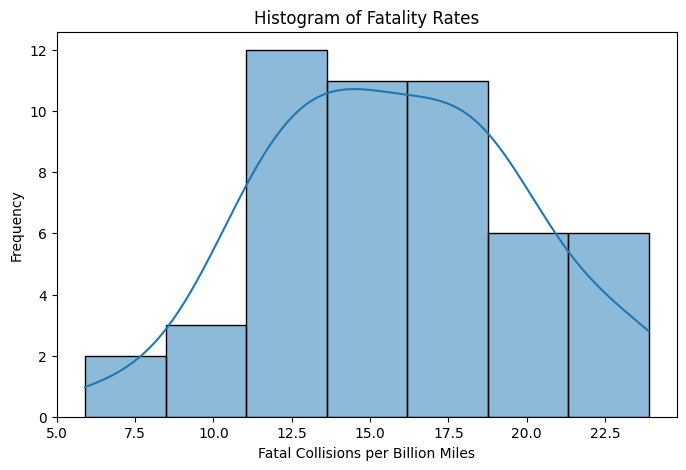

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['number_of_drivers_involved_in_fatal_collisions_per_billion_miles'], kde=True)
plt.title("Histogram of Fatality Rates")
plt.xlabel("Fatal Collisions per Billion Miles")
plt.ylabel("Frequency")
plt.show()

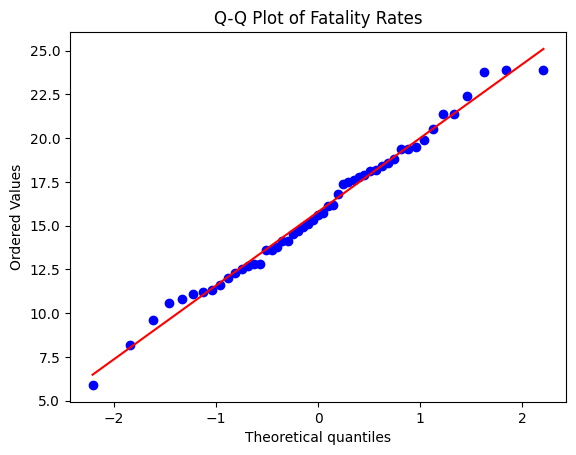

In [ ]:
stats.probplot(df['number_of_drivers_involved_in_fatal_collisions_per_billion_miles'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Fatality Rates")
plt.show()

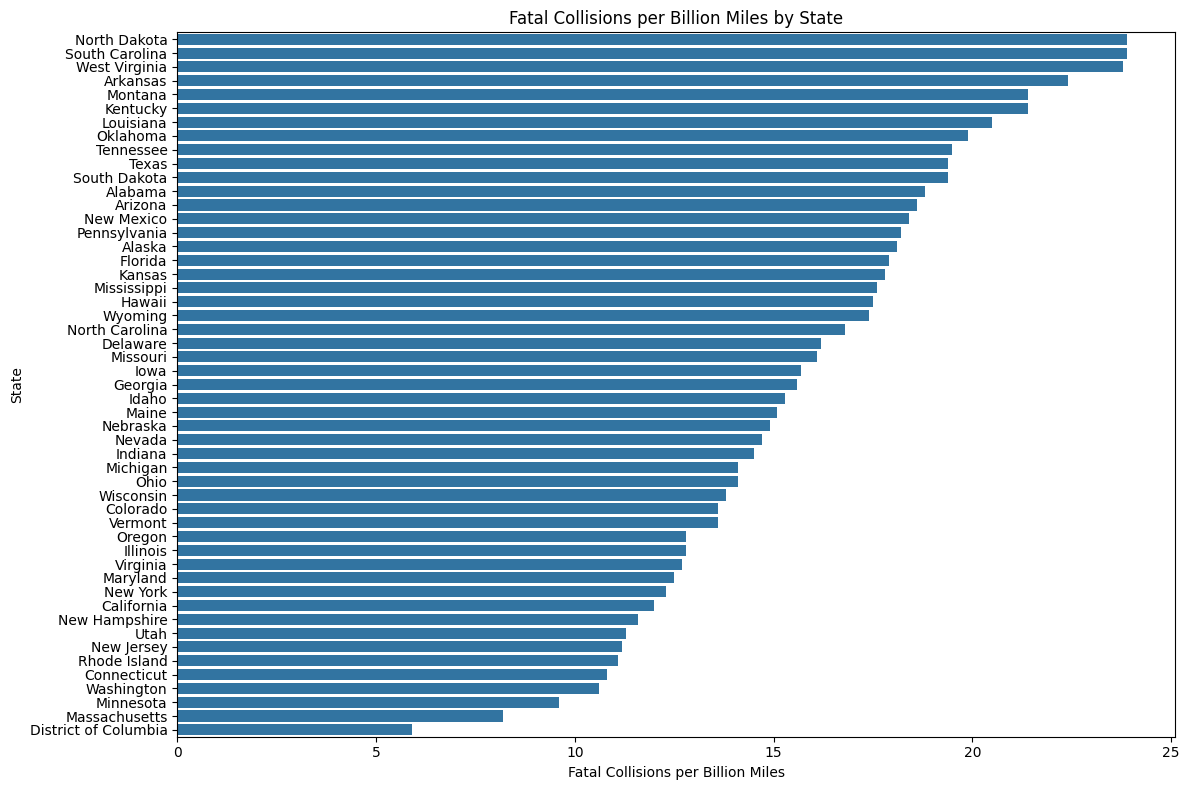

In [ ]:
df_plot = df.sort_values(by='number_of_drivers_involved_in_fatal_collisions_per_billion_miles', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_plot,
    y='state',
    x='number_of_drivers_involved_in_fatal_collisions_per_billion_miles',
)
plt.title('Fatal Collisions per Billion Miles by State')
plt.xlabel('Fatal Collisions per Billion Miles')
plt.ylabel('State')
plt.tight_layout()
plt.show()

I found this really cool [plotting library](https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6) that allows you to create choropleth maps plotted on the US.

[Documentation Link](https://geopandas.org/en/stable/docs.html)

[Example/REfence Link](https://jcutrer.com/python/learn-geopandas-plotting-usmaps)

[Shell Commands](https://rcc-uchicago.github.io/shell-intro/reference/)

In [ ]:
#a bunch of crap that downloads and unzips the files for the statemap
import os
import geopandas as gpd

!wget -O cb_2018_us_state_20m.zip https://github.com/jcraw005/DS2500Data/raw/main/cb_2018_us_state_20m.zip
!unzip -o cb_2018_us_state_20m.zip -d state_shapefile
gdf_states = gpd.read_file("state_shapefile/cb_2018_us_state_20m.shp")

--2025-08-19 16:45:52--  https://github.com/jcraw005/DS2500Data/raw/main/cb_2018_us_state_20m.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jcraw005/DS2500Data/main/cb_2018_us_state_20m.zip [following]
--2025-08-19 16:45:52--  https://raw.githubusercontent.com/jcraw005/DS2500Data/main/cb_2018_us_state_20m.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191218 (187K) [application/zip]
Saving to: ‘cb_2018_us_state_20m.zip’

cb_2018_us_state_20 100%[===================>] 186.74K  --.-KB/s    in 0.004s  

2025-08-19 16:45:52 (45.2 MB/s) - ‘cb_2018_us_state_20m.zip’ saved [191218/191218]

A

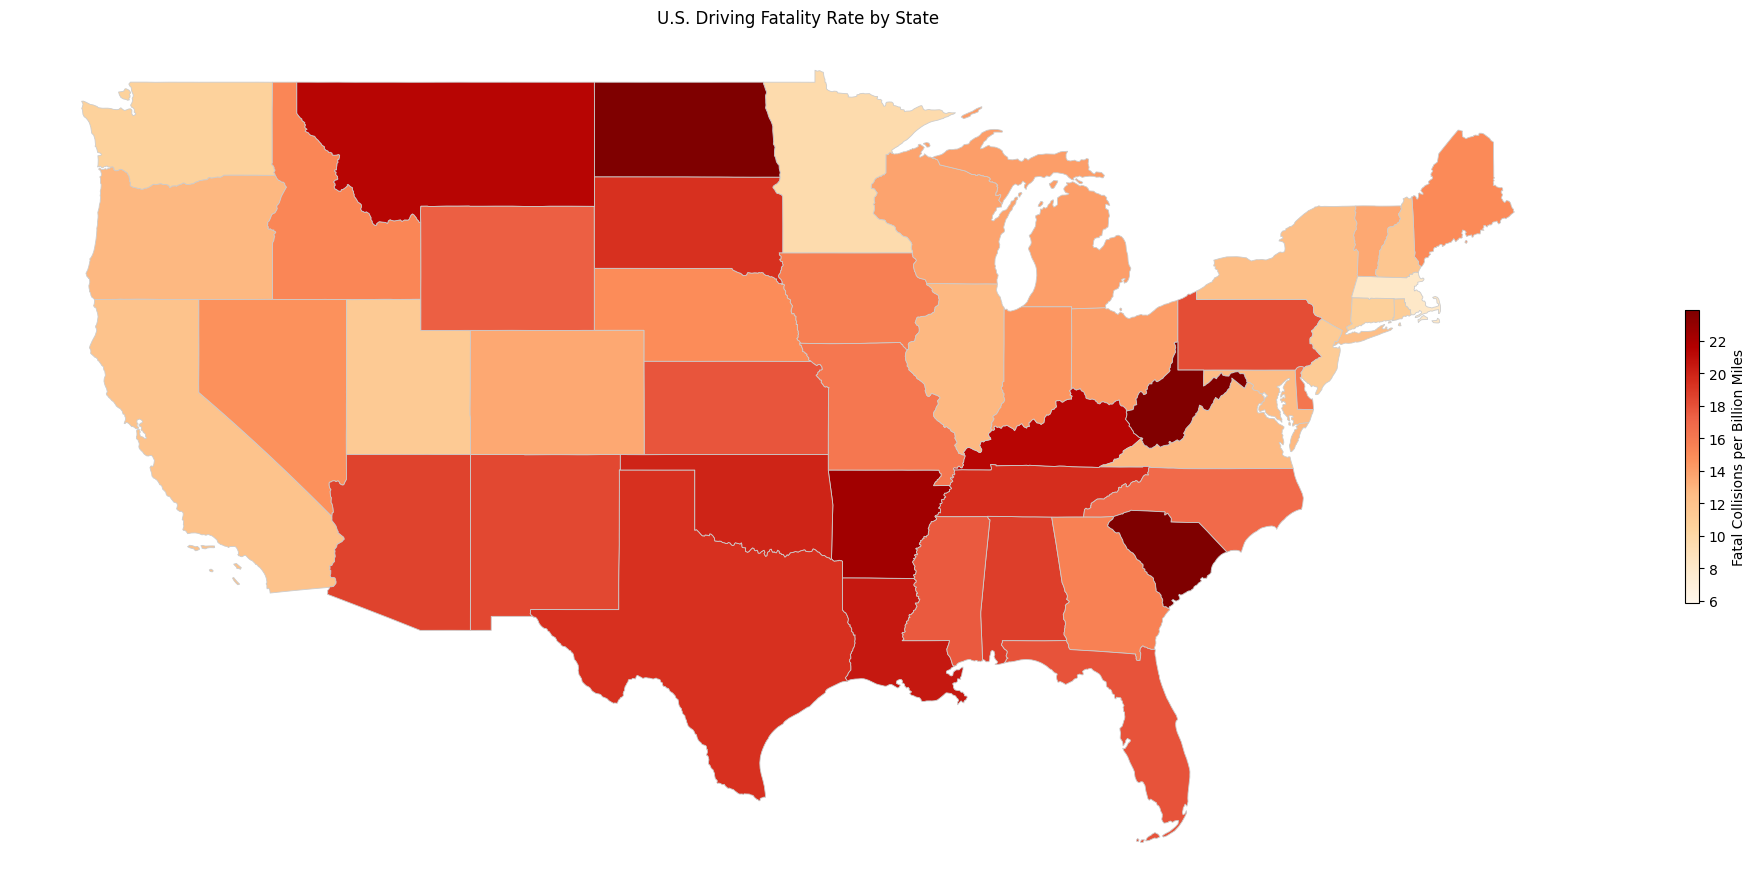

In [ ]:
merged = gdf_states.merge(df, left_on="NAME", right_on="state")

merged = merged.drop(index = merged[merged['NAME'] == 'Alaska'].index)
merged = merged.drop(index = merged[merged['NAME'] == 'Hawaii'].index)

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
merged.plot(
    column='number_of_drivers_involved_in_fatal_collisions_per_billion_miles',
    cmap='OrRd',
    linewidth=0.6,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "Fatal Collisions per Billion Miles", 'shrink': 0.25}
)
ax.set_title("U.S. Driving Fatality Rate by State")
ax.axis('off')
plt.tight_layout()
plt.show()

I for the life of me cannot figure out how to get rid of the Aleutian islands to not make the map rediculusly large, so I just plotted the contiguious US

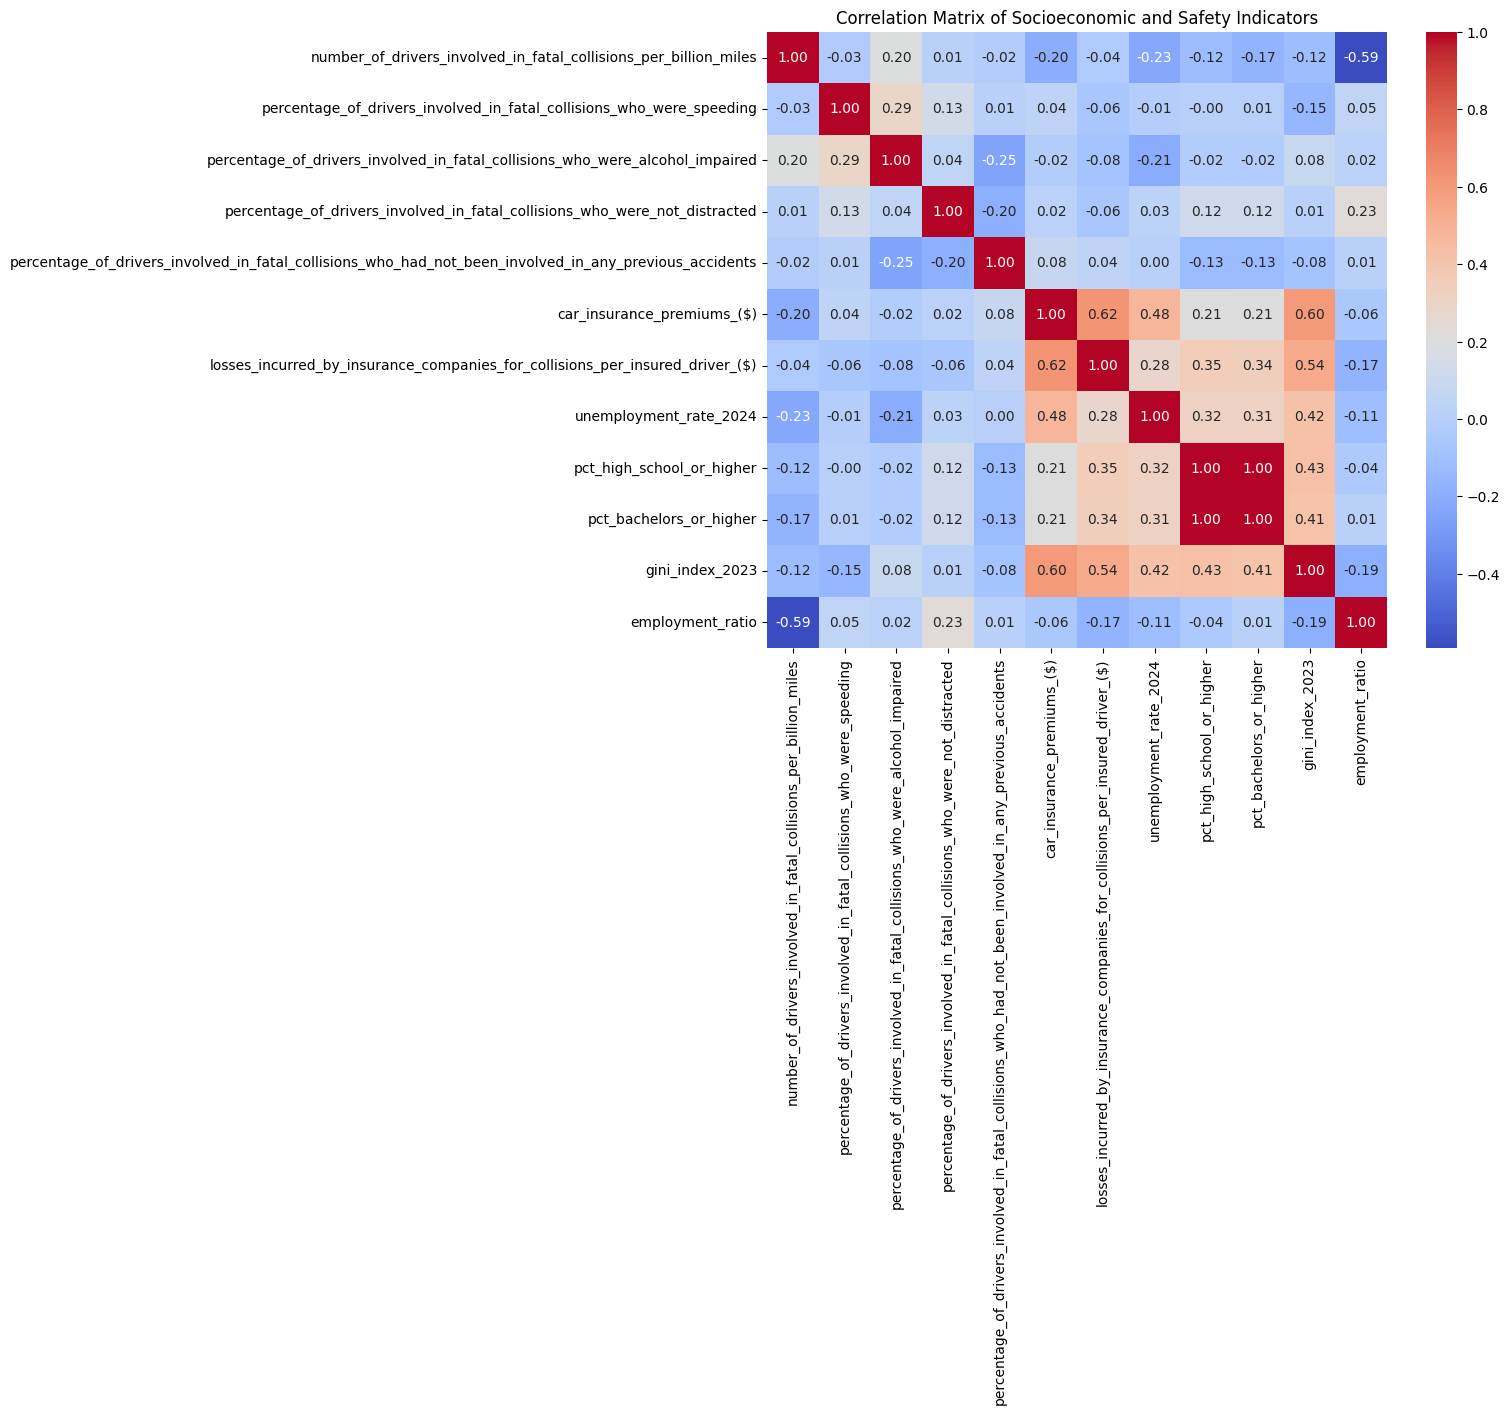

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Socioeconomic and Safety Indicators")

plt.show()

#8. Try an easy solution

In [ ]:
stat, p = shapiro(df['number_of_drivers_involved_in_fatal_collisions_per_billion_miles'])
print(f"Shapiro-Wilk test statistic = {stat:.4f}, p-value = {p:.4f}")

Shapiro-Wilk test statistic = 0.9867, p-value = 0.8354


Because we observe a very high p value from the nshapiro test, we can conclude that the number of fatalities (our dependent variable) is normally distributed.

In [ ]:
model_edu = ols("number_of_drivers_involved_in_fatal_collisions_per_billion_miles ~ "
    "pct_high_school_or_higher + "
    "pct_bachelors_or_higher",
    data=df).fit()
anova_edu = anova_lm(model_edu)
print("Education ANOVA")
print(anova_edu)

Education ANOVA
                             df      sum_sq     mean_sq          F    PR(>F)
pct_high_school_or_higher   1.0   11.994685   11.994685   1.016182  0.318481
pct_bachelors_or_higher     1.0  270.973772  270.973772  22.956720  0.000016
Residual                   48.0  566.576641   11.803680        NaN       NaN


In [ ]:
beh_df = df.copy()
model_beh = ols(
    "number_of_drivers_involved_in_fatal_collisions_per_billion_miles ~ "
    "unemployment_rate_2024 + "
    "gini_index_2023 + "
    "employment_ratio",
    data=beh_df).fit()
anova_beh = anova_lm(model_beh)
print("Behavior ANOVA")
print(anova_beh)

Behavior ANOVA
                          df      sum_sq     mean_sq          F        PR(>F)
unemployment_rate_2024   1.0   44.849556   44.849556   4.562241  3.792324e-02
gini_index_2023          1.0    0.680746    0.680746   0.069248  7.935856e-01
employment_ratio         1.0  341.976731  341.976731  34.786974  3.838531e-07
Residual                47.0  462.038065    9.830597        NaN           NaN


In [ ]:
df.head()
model_econ = ols("number_of_drivers_involved_in_fatal_collisions_per_billion_miles ~ gini_index_2023 + employment_ratio + unemployment_rate_2024", data=df).fit()
anova_econ = anova_lm(model_econ)
print("Economic ANOVA")
print(anova_econ)

Economic ANOVA
                          df      sum_sq     mean_sq          F        PR(>F)
gini_index_2023          1.0   12.748412   12.748412   1.296810  2.605680e-01
employment_ratio         1.0  333.647845  333.647845  33.939733  4.934788e-07
unemployment_rate_2024   1.0   41.110775   41.110775   4.181920  4.647943e-02
Residual                47.0  462.038065    9.830597        NaN           NaN


In [ ]:
ovr_df = df.copy()
ovr_df.rename(columns={
    'percentage_of_drivers_involved_in_fatal_collisions_who_were_alcohol_impaired' : 'alcohol_impared',
    'percentage_of_drivers_involved_in_fatal_collisions_who_were_not_distracted' : 'distracted',
    'percentage_of_drivers_involved_in_fatal_collisions_who_were_speeding' : 'speeding',
    'percentage_of_drivers_involved_in_fatal_collisions_who_had_not_been_involved_in_any_previous_accidents' : 'prev_accidents',
    'car_insurance_premiums_($)' : 'insureance_prem',
    'losses_incurred_by_insurance_companies_for_collisions_per_insured_driver_($)' : 'insurance_losses'
}, inplace = True)


model_ovr = ols(
    "number_of_drivers_involved_in_fatal_collisions_per_billion_miles ~"
    "alcohol_impared + "
    "distracted + "
    "speeding + "
    "prev_accidents + "
    "insureance_prem + "
    "insurance_losses + "
    "unemployment_rate_2024 + "
    "pct_high_school_or_higher + "
    "pct_bachelors_or_higher + "
    "gini_index_2023 + "
    "employment_ratio",
    data=ovr_df).fit()
anova_ovr = anova_lm(model_ovr)
print("All Variables - ANOVA")
print(anova_ovr)

All Variables - ANOVA
                             df      sum_sq     mean_sq          F    PR(>F)
alcohol_impared             1.0   33.787145   33.787145   3.716102  0.061195
distracted                  1.0    0.001088    0.001088   0.000120  0.991327
speeding                    1.0    7.000598    7.000598   0.769965  0.385601
prev_accidents              1.0    1.628584    1.628584   0.179121  0.674455
insureance_prem             1.0   32.633822   32.633822   3.589253  0.065587
insurance_losses            1.0   14.161937   14.161937   1.557610  0.219457
unemployment_rate_2024      1.0    8.055210    8.055210   0.885958  0.352369
pct_high_school_or_higher   1.0    7.253227    7.253227   0.797751  0.377245
pct_bachelors_or_higher     1.0  252.002497  252.002497  27.716664  0.000005
gini_index_2023             1.0    6.437519    6.437519   0.708035  0.405227
employment_ratio            1.0  131.991825  131.991825  14.517209  0.000481
Residual                   39.0  354.591646    9.09209

In [ ]:
df_numeric = df.select_dtypes(include='number')
X_all = df_numeric.drop(columns=[
    'number_of_drivers_involved_in_fatal_collisions_per_billion_miles'
    ], errors='ignore')
X_all = sm.add_constant(X_all)
y_all = df_numeric['number_of_drivers_involved_in_fatal_collisions_per_billion_miles']

model_all = sm.OLS(y_all, X_all).fit()
print(model_all.summary())

                                                   OLS Regression Results                                                   
Dep. Variable:     number_of_drivers_involved_in_fatal_collisions_per_billion_miles   R-squared:                       0.583
Model:                                                                          OLS   Adj. R-squared:                  0.465
Method:                                                               Least Squares   F-statistic:                     4.949
Date:                                                              Tue, 19 Aug 2025   Prob (F-statistic):           9.05e-05
Time:                                                                      16:45:55   Log-Likelihood:                -121.81
No. Observations:                                                                51   AIC:                             267.6
Df Residuals:                                                                    39   BIC:                             290.8


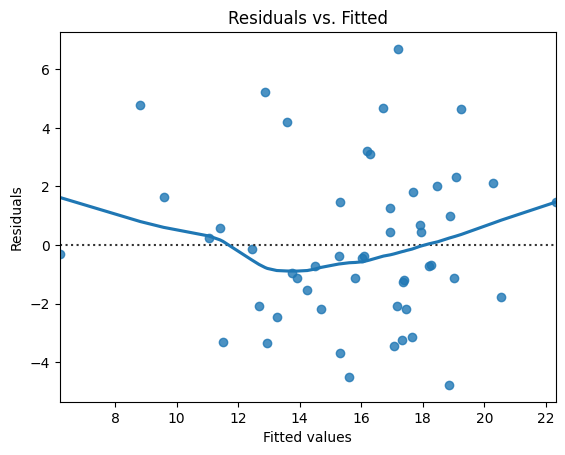

In [ ]:
residuals = model_all.resid
fitted = model_all.fittedvalues

sns.residplot(x=fitted, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()

Lets try with only the significant predictors (using alpha = 0.05)

In [ ]:
significant_predictors = model_all.pvalues[model_all.pvalues < 0.05].index
significant_predictors = [col for col in significant_predictors if col != 'const'] #filter out the intercept, as it was sig.

In [ ]:
X_sig = sm.add_constant(df_numeric[significant_predictors])
model_sig = sm.OLS(y_all, X_sig).fit()
print(model_sig.summary())

                                                   OLS Regression Results                                                   
Dep. Variable:     number_of_drivers_involved_in_fatal_collisions_per_billion_miles   R-squared:                       0.376
Model:                                                                          OLS   Adj. R-squared:                  0.350
Method:                                                               Least Squares   F-statistic:                     14.47
Date:                                                              Tue, 19 Aug 2025   Prob (F-statistic):           1.21e-05
Time:                                                                      16:45:55   Log-Likelihood:                -132.06
No. Observations:                                                                51   AIC:                             270.1
Df Residuals:                                                                    48   BIC:                             275.9


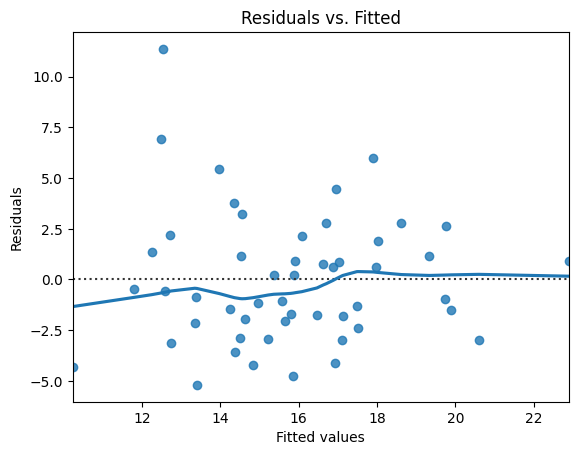

In [ ]:
residuals = model_sig.resid
fitted = model_sig.fittedvalues

sns.residplot(x=fitted, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()

Both the R^2 and adj R^2 dropped, meaning the model does not fit as well as the orginal. Lets try upping the apha to 0.1, (90% CI)

In [ ]:
significant_predictors = model_all.pvalues[model_all.pvalues < 0.1].index
significant_predictors = [col for col in significant_predictors if col != 'const'] #filter out the intercept, as it was sig.

In [ ]:
X_sig = sm.add_constant(df_numeric[significant_predictors])
model_sig = sm.OLS(y_all, X_sig).fit()
print(model_sig.summary())

                                                   OLS Regression Results                                                   
Dep. Variable:     number_of_drivers_involved_in_fatal_collisions_per_billion_miles   R-squared:                       0.480
Model:                                                                          OLS   Adj. R-squared:                  0.435
Method:                                                               Least Squares   F-statistic:                     10.63
Date:                                                              Tue, 19 Aug 2025   Prob (F-statistic):           3.49e-06
Time:                                                                      16:45:56   Log-Likelihood:                -127.40
No. Observations:                                                                51   AIC:                             264.8
Df Residuals:                                                                    46   BIC:                             274.5


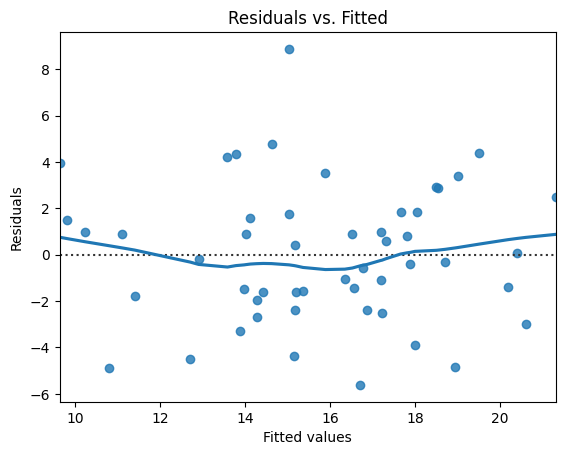

In [ ]:
residuals = model_sig.resid
fitted = model_sig.fittedvalues

sns.residplot(x=fitted, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()

In [ ]:
ovr_df = df.select_dtypes(include='number')
ovr_df.rename(columns={
    'percentage_of_drivers_involved_in_fatal_collisions_who_were_alcohol_impaired' : 'alcohol_impared',
    'percentage_of_drivers_involved_in_fatal_collisions_who_were_not_distracted' : 'distracted',
    'percentage_of_drivers_involved_in_fatal_collisions_who_were_speeding' : 'speeding',
    'percentage_of_drivers_involved_in_fatal_collisions_who_had_not_been_involved_in_any_previous_accidents' : 'prev_accidents',
    'car_insurance_premiums_($)' : 'insureance_prem',
    'losses_incurred_by_insurance_companies_for_collisions_per_insured_driver_($)' : 'insurance_losses'
}, inplace = True)


X_all = ovr_df.drop(columns=[
    'number_of_drivers_involved_in_fatal_collisions_per_billion_miles',
    'pct_bachelors_or_higher',
    'insurance_losses',
    'unemployment_rate_2024',
    'gini_index_2023',

    ], errors='ignore')
X_all = sm.add_constant(X_all)
y_all = ovr_df['number_of_drivers_involved_in_fatal_collisions_per_billion_miles']

model_all = sm.OLS(y_all, X_all).fit()
print(model_all.summary())

                                                   OLS Regression Results                                                   
Dep. Variable:     number_of_drivers_involved_in_fatal_collisions_per_billion_miles   R-squared:                       0.495
Model:                                                                          OLS   Adj. R-squared:                  0.413
Method:                                                               Least Squares   F-statistic:                     6.016
Date:                                                              Tue, 19 Aug 2025   Prob (F-statistic):           6.37e-05
Time:                                                                      16:45:56   Log-Likelihood:                -126.68
No. Observations:                                                                51   AIC:                             269.4
Df Residuals:                                                                    43   BIC:                             284.8
